In [3]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

pd.options.display.max_columns = 50


In [5]:
start, end = "2015-01-01", None  # None = today
tickers = ["NVDA","SPY","SOXX","AMD"]

data = yf.download(tickers, start=start, end=end, auto_adjust=False)

# Handle both possible column shapes from yfinance
import pandas as pd
if isinstance(data.columns, pd.MultiIndex):
    # columns look like: (ticker, field) OR (field, ticker).
    # Try to slice by field name no matter which level it is.
    if 'Adj Close' in data.columns.get_level_values(-1):
        # last level is the field name
        raw = data.xs('Adj Close', axis=1, level=-1).dropna()
    elif 'Adj Close' in data.columns.get_level_values(0):
        # first level is the field name
        raw = data.xs('Adj Close', axis=1, level=0).dropna()
    else:
        raise KeyError("Could not find 'Adj Close' in yfinance columns.")
else:
    # Single-level columns (usually when only 1 ticker)
    # Keep just Adj Close and rename to the ticker for consistency
    if 'Adj Close' not in data.columns:
        raise KeyError("Could not find 'Adj Close' in yfinance columns.")
    # If multiple tickers requested but we still got single level, pick NVDA
    raw = data[['Adj Close']].rename(columns={'Adj Close': tickers[0]}).dropna()

raw.tail()


[*********************100%***********************]  4 of 4 completed


Ticker,AMD,NVDA,SOXX,SPY
Date,,,,
2025-08-21,163.710007,174.979996,242.360001,635.549988
2025-08-22,167.759995,177.990005,249.089996,645.309998
2025-08-25,163.360001,179.809998,248.509995,642.469971
2025-08-26,166.619995,181.770004,250.850006,645.159973
2025-08-27,167.130005,181.600006,251.339996,646.630005


In [7]:
# build features for NVDA
rets = raw.pct_change()
nvda = pd.DataFrame(index=raw.index)
nvda["price"] = raw["NVDA"]

# momentum (approx 1m, 3m)
nvda["ret1m"] = raw["NVDA"].pct_change(21)
nvda["ret3m"] = raw["NVDA"].pct_change(63)

# trend
nvda["ma50"]  = raw["NVDA"].rolling(50).mean()
nvda["ma200"] = raw["NVDA"].rolling(200).mean()
nvda["trend"] = (nvda["ma50"] - nvda["ma200"]) / nvda["ma200"]

# volatility
nvda["vol20"] = rets["NVDA"].rolling(20).std()

# relative strength
nvda["rel_mkt_20"]  = rets["NVDA"].rolling(20).sum() - rets["SPY"].rolling(20).sum()
nvda["rel_semi_20"] = rets["NVDA"].rolling(20).sum() - rets["SOXX"].rolling(20).sum()
nvda["rel_amd_20"]  = rets["NVDA"].rolling(20).sum() - rets["AMD"].rolling(20).sum()

# label: will next 20 trading days be positive?
future_ret20 = raw["NVDA"].pct_change(20).shift(-20)
nvda["y"] = (future_ret20 > 0).astype(int)

# final dataset
feat_cols = ["ret1m","ret3m","trend","vol20","rel_mkt_20","rel_semi_20","rel_amd_20"]
df = nvda[feat_cols + ["y"]].dropna()
df.tail()


,ret1m,ret3m,trend,vol20,rel_mkt_20,rel_semi_20,rel_amd_20,y
Date,,,,,,,,
2025-08-21,0.024593,0.327710,0.208274,0.015534,0.007189,0.003981,-0.010209,0
2025-08-22,0.024462,0.340076,0.211507,0.015967,0.014640,-0.005286,0.010467,0
2025-08-25,0.036369,0.369659,0.214629,0.015590,0.010283,0.005965,0.071379,0
2025-08-26,0.028402,0.341569,0.218545,0.015621,0.021374,0.016255,0.091106,0
2025-08-27,0.034699,0.347175,0.222292,0.014933,-0.004522,-0.000908,0.077353,0


In [9]:
# Training & testing with walk-forward splits
X = df[feat_cols].values
y = df["y"].values

tscv = TimeSeriesSplit(n_splits=5)
preds, trues, proba_list, idx_list = [], [], [], []

for train_idx, test_idx in tscv.split(X):
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y[train_idx], y[test_idx]

    model = RandomForestClassifier(n_estimators=300, random_state=42)
    model.fit(Xtr, ytr)

    p = model.predict(Xte)
    prob = model.predict_proba(Xte)[:, 1]

    preds.extend(p.tolist())
    trues.extend(yte.tolist())
    proba_list.extend(prob.tolist())
    idx_list.extend(test_idx.tolist())

import numpy as np
test_index = np.array(idx_list)           # <— keep an explicit copy for the next cell
print("Directional accuracy:", round(accuracy_score(trues, preds), 3))


Directional accuracy: 0.571


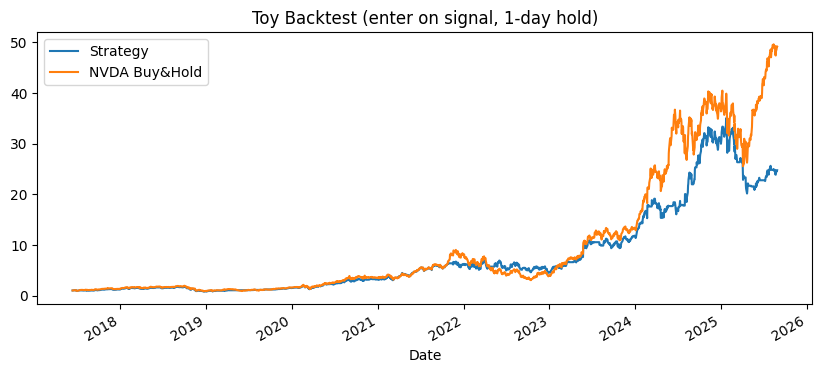

In [10]:
# Toy backtest: buy when model says "up" (p>=0.5), hold 1 day
test_dates = df.index[test_index]   # uses the explicit test_index from Cell 4
daily_nvda_ret = raw["NVDA"].pct_change().reindex(test_dates).fillna(0.0)

signal = pd.Series((np.array(proba_list) >= 0.5).astype(int), index=test_dates, name="signal")
strat_ret = signal * daily_nvda_ret
eq_curve = (1 + strat_ret).cumprod()

# Buy-and-hold NVDA for comparison
bh = (1 + daily_nvda_ret).cumprod()

ax = eq_curve.plot(figsize=(10, 4), label="Strategy")
bh.plot(ax=ax, label="NVDA Buy&Hold")
plt.title("Toy Backtest (enter on signal, 1-day hold)")
plt.legend(); plt.show()


In [11]:
# Chronological split: first 80% train, last 20% test
n = len(df)
split = int(n * 0.8)

X_train, X_test = df[feat_cols].iloc[:split].values, df[feat_cols].iloc[split:].values
y_train, y_test = df["y"].iloc[:split].values, df["y"].iloc[split:].values
dates_test = df.index[split:]  # keep test dates (useful later)

holdout_clf = RandomForestClassifier(n_estimators=300, random_state=42)
holdout_clf.fit(X_train, y_train)

y_pred = holdout_clf.predict(X_test)
y_prob = holdout_clf.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, classification_report
print("Holdout accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))


Holdout accuracy: 0.536

Classification report:
               precision    recall  f1-score   support

           0      0.308     0.229     0.263       179
           1      0.620     0.710     0.662       317

    accuracy                          0.536       496
   macro avg      0.464     0.469     0.462       496
weighted avg      0.507     0.536     0.518       496



<Figure size 500x400 with 0 Axes>

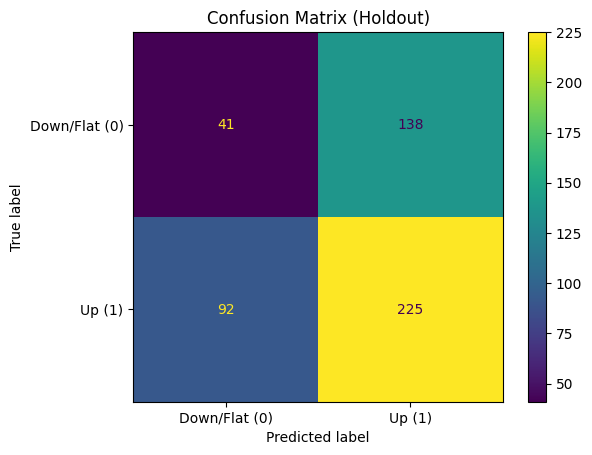

Precision: 0.62
Recall   : 0.71
F1       : 0.662


In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down/Flat (0)", "Up (1)"])

plt.figure(figsize=(5,4))
disp.plot(values_format='d')
plt.title("Confusion Matrix (Holdout)")
plt.show()

print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall   :", round(recall_score(y_test, y_pred), 3))
print("F1       :", round(f1_score(y_test, y_pred), 3))


In [13]:
# Find a good threshold using the training portion (simple grid search on F1)
from sklearn.metrics import f1_score

probs_train = holdout_clf.predict_proba(X_train)[:, 1]
best_t, best_f1 = 0.5, -1
for t in [i/100 for i in range(20, 81)]:  # 0.20..0.80
    preds_t = (probs_train >= t).astype(int)
    f1 = f1_score(y_train, preds_t)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"Chosen threshold on train: {best_t:.2f} (F1={best_f1:.3f})")

# Apply chosen threshold to test set
y_pred_t = (y_prob >= best_t).astype(int)
print("Test F1 at chosen threshold:", round(f1_score(y_test, y_pred_t), 3))


Chosen threshold on train: 0.39 (F1=1.000)
Test F1 at chosen threshold: 0.731


In [14]:
# Find a good threshold using the training portion (simple grid search on F1)
from sklearn.metrics import f1_score

probs_train = holdout_clf.predict_proba(X_train)[:, 1]
best_t, best_f1 = 0.5, -1
for t in [i/100 for i in range(20, 81)]:  # 0.20..0.80
    preds_t = (probs_train >= t).astype(int)
    f1 = f1_score(y_train, preds_t)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"Chosen threshold on train: {best_t:.2f} (F1={best_f1:.3f})")

# Apply chosen threshold to test set
y_pred_t = (y_prob >= best_t).astype(int)
print("Test F1 at chosen threshold:", round(f1_score(y_test, y_pred_t), 3))


Chosen threshold on train: 0.39 (F1=1.000)
Test F1 at chosen threshold: 0.731


In [15]:
# Re-download to today and rebuild 'raw' quickly (same tickers)
start = "2015-01-01"
data = yf.download(tickers, start=start, end=None, auto_adjust=False)

# Handle columns again (same logic as before)
if isinstance(data.columns, pd.MultiIndex):
    if 'Adj Close' in data.columns.get_level_values(-1):
        raw = data.xs('Adj Close', axis=1, level=-1).dropna()
    elif 'Adj Close' in data.columns.get_level_values(0):
        raw = data.xs('Adj Close', axis=1, level=0).dropna()
    else:
        raise KeyError("Could not find 'Adj Close'")
else:
    if 'Adj Close' not in data.columns:
        raise KeyError("Could not find 'Adj Close'")
    raw = data[['Adj Close']].rename(columns={'Adj Close': tickers[0]}).dropna()

raw.tail()  # sanity check latest row is today or last market day


[*********************100%***********************]  4 of 4 completed


Ticker,AMD,NVDA,SOXX,SPY
Date,,,,
2025-08-21,163.710007,174.979996,242.360001,635.549988
2025-08-22,167.759995,177.990005,249.089996,645.309998
2025-08-25,163.360001,179.809998,248.509995,642.469971
2025-08-26,166.619995,181.770004,250.850006,645.159973
2025-08-27,167.130005,181.600006,251.339996,646.630005
